In [1]:
dogs = [
 'n02085620','n02085782','n02085936','n02086079'
,'n02086240','n02086646','n02086910','n02087046'
,'n02087394','n02088094','n02088238','n02088364'
,'n02088466','n02088632','n02089078','n02089867'
,'n02089973','n02090379','n02090622','n02090721'
,'n02091032','n02091134','n02091244','n02091467'
,'n02091635','n02091831','n02092002','n02092339'
,'n02093256','n02093428','n02093647','n02093754'
,'n02093859','n02093991','n02094114','n02094258'
,'n02094433','n02095314','n02095570','n02095889'
,'n02096051','n02096177','n02096294','n02096437'
,'n02096585','n02097047','n02097130','n02097209'
,'n02097298','n02097474','n02097658','n02098105'
,'n02098286','n02098413','n02099267','n02099429'
,'n02099601','n02099712','n02099849','n02100236'
,'n02100583','n02100735','n02100877','n02101006'
,'n02101388','n02101556','n02102040','n02102177'
,'n02102318','n02102480','n02102973','n02104029'
,'n02104365','n02105056','n02105162','n02105251'
,'n02105412','n02105505','n02105641','n02105855'
,'n02106030','n02106166','n02106382','n02106550'
,'n02106662','n02107142','n02107312','n02107574'
,'n02107683','n02107908','n02108000','n02108089'
,'n02108422','n02108551','n02108915','n02109047'
,'n02109525','n02109961','n02110063','n02110185'
,'n02110341','n02110627','n02110806','n02110958'
,'n02111129','n02111277','n02111500','n02111889'
,'n02112018','n02112137','n02112350','n02112706'
,'n02113023','n02113186','n02113624','n02113712'
,'n02113799','n02113978']

cats=['n02123045','n02123159','n02123394','n02123597','n02124075','n02125311','n02127052']

## 文件操作

In [1]:
import os
import shutil 
import random
from tqdm import *

TRAIN_PATH = "./train/"
TEST_PATH = "./test/"

def checkDir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
checkDir('train_link')
checkDir('train_link/dog')
checkDir('train_link/cat')
checkDir('test_link')
train_files = os.listdir(TRAIN_PATH)

In [2]:
def createLink():
    train_files = os.listdir(TRAIN_PATH)
    os.symlink('../test/', 'test_link/test')
    for filename in tqdm(train_files):
        if 'dog' in filename:
            if os.path.exists('train_link/dog/' + filename):
                continue
            os.symlink('../../train/'+filename, 'train_link/dog/' + filename)
        else:
            if os.path.exists('train_link/cat/' + filename):
                continue
            os.symlink('../../train/' + filename, 'train_link/cat/' + filename)

In [3]:
import json
def readOutliers():
    with open('outliers.json', 'r') as json_file:
        return json.load(json_file)

In [4]:
def writeOutliers(key, files):
    with open('outliers.json', 'r+') as json_file:
            try:
                outliers_dict = json.load(json_file)
#                 print(outliers_dict)
            except:
                outliers_dict = {}
            outliers_dict[key] = files
            json_file.close()
    with open('outliers.json','w') as json_file:
        json_file.write(json.dumps(outliers_dict))
        json_file.close()
        
# writeOutliers('key3',['1','2','3','555'])

### 数据处理

In [20]:
import cv2
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab as plb
from keras.models import Model
from keras.layers import Input, Flatten, Dropout, Dense,Lambda
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications import Xception, InceptionResNetV2, DenseNet201
import json as js
from tqdm import *
from keras.preprocessing.image import *
import h5py
from keras.applications import *
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard


In [6]:
import sys
def get_train_test_data(height, doc_files = train_files):
    labels = np.zeros(len(train_files))
    train = np.zeros((len(train_files), height, height, 3), dtype=np.uint8)
    test = np.zeros((12500, height, height, 3), dtype=np.uint8)
    for idx, file in enumerate(tqdm(train_files)):
        img = cv2.imread(TRAIN_PATH + file)
        img = cv2.resize(img, (height, height))
        train[idx] = img[:, :, ::-1]
        if 'dog' in file:
            labels[idx] = 1
    for i in tqdm(range(12500)):
        img = cv2.imread('./test/%s.jpg' % str(i + 1))
        img = cv2.resize(img, (height, height))
        test[i] = img[:, :, ::-1]
    print('Training Data Size = %.2f GB' % (sys.getsizeof(train)/1024**3))
    print('Testing Data Size = %.2f GB' % (sys.getsizeof(test)/1024**3))
    return train, test,labels

###  数据可视化

In [6]:
imgs = []
for file in train_files:
    img = cv2.imread(TRAIN_PATH + file)
    imgs.append(img.shape[0:2])
#     break
    
imgs = np.array(imgs)
x = imgs[:,0]
y = imgs[:,1]

Populating the interactive namespace from numpy and matplotlib


/home/ec2-user/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', '__version__', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


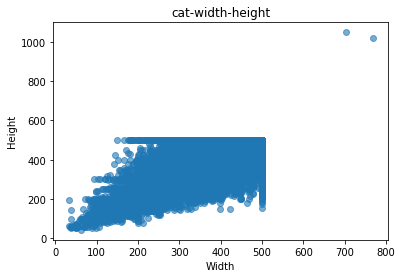

In [7]:
%pylab inline
plt.title('cat-width-height')
plt.xlabel('Width')
plt.ylabel('Height')
plt.scatter(x, y, alpha = 0.6)
plt.show()

### 数据预处理
- 加载ImageNet猫狗的预测结果对比数据

- 结合 Xception，InceptionResNetV2， DenseNet201 完成异常值检测

In [6]:
%pylab inline
from PIL import Image
subplots_adjust(left=0.0,bottom=0.0,top=0.1,right=0.1,hspace = 0)
def showImge(files, doc= './train/', size = (12,12)):
    fig = plt.figure(num= 'astronaut',figsize=size)
    row = int(len(files) / 5 if len(files) % 5 == 0 else len(files) / 5 + 1)
#     print(row)
    for idx,file in enumerate(tqdm(files)):
        img = Image.open(doc + file)    
        plt.axis('on') # 关掉坐标轴为 off
        plt.subplot(row,5,idx + 1)
        plt.tight_layout()
        plt.title(file)
        fig.set_size_inches(20.5, 20.5 * row / 5,forward=True)
        plt.imshow(img)
    plt.show()
# %pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/ec2-user/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shuffle', 'random', '__version__']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<Figure size 432x288 with 0 Axes>

In [7]:
def process_outliers(files,model,preprocess_input, target_size=(299, 299),top = 20):
    outlier_files = []
    np_cats = np.array(cats)
    np_dogs = np.array(dogs)
    for file in tqdm(files):
        img = image.load_img(TRAIN_PATH + file, target_size=target_size)
    #     print("file:", file)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        preds = model.predict(x)
        pred = decode_predictions(preds, top= top)[0]
        # 取交集
        if 'dog' in file:
            intersections = np.intersect1d(np.array(pred)[:,0],np_dogs)
        else:
            intersections = np.intersect1d(np.array(pred)[:,0],np_cats)

        if len(intersections) == 0:
            outlier_files.append(file)
    return outlier_files

##### 使用 Xception， InceptionResNetV2，InceptionV3，DenseNet201，分别取不同合理的top对数据检测异常值

In [8]:
# Xception 
from keras.applications.xception import preprocess_input as pre_x
model = Xception(include_top=True,weights='imagenet')

In [8]:
# 先取1000个数据，使用top= 10,20,30,40,50 对数据检查异常值
outliers = process_outliers(train_files[:1000],model,pre_x,top=10)
# showImge(outliers)

100%|██████████| 1000/1000 [03:19<00:00,  5.02it/s]


##### Top = 10，误差还是很大的，对已经1000张已经检测出是异常值的猫狗图片，top = 20重新进行筛选检测。

In [ ]:
outliers_20 = process_outliers(outliers,model,pre_x,top=20)
# showImge(outliers_20)

###### 发现top=20 还是有点误差，将top=30，40，50，60,70,80,检测范围提升至5000

In [ ]:
# top 30 检测大小提升至5000
outliers_80 = process_outliers(outliers_70,model,pre_x,top=80)
# showImge(outliers_80)

##### TOP 调整至80后，发现异常值误差有明显的降低，使用top = 80 对所有的训练集做检测。

In [ ]:
outliers_Vception = process_outliers(outliers_Vception,model,pre_x, top=80)
# showImge(outliers_Vception)

In [22]:
### 将此模型的异常值保存为json文件
writeOutliers('Xception',outliers_Vception)

#### 调整top提高精确度

In [16]:
outliers_Xception = readOutliers()['Xception']
outliers_Xception = process_outliers(outliers_Xception, model,pre_x, top=110)
# showImge(outliers_Xception)
writeOutliers('Xception_110',outliers_Xception)

100%|██████████| 42/42 [00:01<00:00, 24.03it/s]


##### InceptionResNetV2 检测异常值

In [13]:
from keras.applications.inception_resnet_v2 import preprocess_input as pre_ResNetV2
resNetV2Model = InceptionResNetV2(weights= 'imagenet')

In [ ]:
outliers_InceptionResNetV2 = process_outliers(outliers_InceptionResNetV2, resNetV2Model,pre_ResNetV2, top=80)
writeOutliers('InceptionResNetV2',outliers_InceptionResNetV2)

In [21]:
outliers_InceptionResNetV2 = readOutliers()['InceptionResNetV2']
outliers_InceptionResNetV2 = process_outliers(outliers_InceptionResNetV2, resNetV2Model,pre_ResNetV2, top=120)
# showImge(outliers_InceptionResNetV2)
writeOutliers('InceptionResNetV2_120',outliers_InceptionResNetV2)

100%|██████████| 39/39 [00:03<00:00, 11.16it/s]


#### 使用DenseNet201检测异常值调整top。

In [22]:
from keras.applications.densenet import preprocess_input as dense_pre
dense_model = DenseNet201(weights='imagenet')

In [10]:
outliers_dense = process_outliers(train_files, dense_model, dense_pre, top=80,target_size=(224,224))

100%|██████████| 25000/25000 [32:12<00:00, 12.93it/s]


In [25]:
outliers_dense = readOutliers()['DenseNet201']
outliers_dense = process_outliers(outliers_dense, dense_model, dense_pre, top=100,target_size=(224,224))
writeOutliers('DenseNet201_100',outliers_dense)
# showImge(outliers_dense)

100%|██████████| 42/42 [00:03<00:00, 12.59it/s]


##### 使用InceptionV3继续检测

In [26]:
from keras.applications.inception_v3 import preprocess_input as v3_pre
from keras.applications import InceptionV3
v3_model = InceptionV3(weights = 'imagenet')

In [39]:
# outliers_v3 = process_outliers(train_files, v3_model, v3_pre, top= 80, target_size = (224, 224))
# showImge(outliers_v3)
writeOutliers('InceptionV3', outliers_v3)

In [35]:
outliers_v3 = readOutliers()['InceptionV3']
outliers_v3 = process_outliers(outliers_v3, v3_model, v3_pre, top= 190, target_size = (224, 224))
# showImge(outliers_v3) 
writeOutliers('InceptionV3_190',outliers_v3)

100%|██████████| 64/64 [00:02<00:00, 25.11it/s]


### 对以上四个模型的异常值取并集

In [7]:
def getAllOutliers():
    out_keys = ['Xception_110', 'InceptionResNetV2_120', 'DenseNet201_120', 'InceptionV3_190']
    outliers = []
    outliersDict = readOutliers()
    for k in out_keys:
        outliers = list(set(outliers).union(set(readOutliers()[k])))
    return outliers
# len(getAllOutliers())
# showImge(getAllOutliers())
# writeOutliers('outliers_all',getAllOutliers())
for file in getAllOutliers():
    os.remove(TRAIN_PATH + file)
    if 'dog' in file:
        os.remove('train_link/dog/' + file)
    else:
        os.remove('train_link/cat/' + file)

### 数据预处理

In [38]:
train, test,labels = get_train_test_data(299)

100%|██████████| 12500/12500 [00:35<00:00, 355.27it/s]


Training Data Size = 6.23 GB
Testing Data Size = 3.12 GB


In [40]:
def get_features_gap(MODEL, target_size, lambda_func = None):
    # Preprocess: Standardization
    input_tensor = Input((target_size[1], target_size[0], 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)
    # Base Model: Extract feature vector of both train & test dataset
    base_model = MODEL(input_tensor = x, weights='imagenet', include_top=False, pooling = 'avg')
#     model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))
    train_gap = base_model.predict(train, batch_size=128)
    test_gap = base_model.predict(test, batch_size=128)
    with h5py.File("gap_%s.h5"%MODEL.__name__) as h:
        h.create_dataset("train", data=train_gap)
        h.create_dataset("test", data=test_gap)
        h.create_dataset("label", data=labels)

In [41]:
get_features_gap(InceptionV3, (299,299), inception_v3.preprocess_input)

In [43]:
train, test,labels = get_train_test_data(224)
get_features_gap(ResNet50, (224,224), resnet50.preprocess_input)

100%|██████████| 12500/12500 [00:29<00:00, 421.59it/s]


Training Data Size = 3.50 GB
Testing Data Size = 1.75 GB


In [ ]:
train, test,labels = get_train_test_data(299)
get_features_gap(InceptionResNetV2, (299,299), inception_resnet_v2.preprocess_input)

100%|██████████| 12500/12500 [00:35<00:00, 355.98it/s]


Training Data Size = 6.23 GB
Testing Data Size = 3.12 GB
219062272/219055592 [==============================] - 2s 0us/step


### 模型融合

In [26]:
from sklearn.utils import shuffle
np.random.seed(2017)
x_train = []
x_test = []
for file in ['gap_InceptionV3', 'gap_InceptionResNetV2', 'gap_ResNet50']:
    with h5py.File(file + '.h5', 'r') as h:
        x_train.append(np.array(h['train']))
        x_test.append(np.array(h['test']))
        y_train = np.array(h['label'])
x_train = np.concatenate(x_train, axis=1)
x_test = np.concatenate(x_test, axis=1)
x_train, y_train = shuffle(x_train, y_train)

In [27]:
from sklearn.model_selection import train_test_split

X_train_gap, X_val_gap, y_train_gap, y_val_gap = train_test_split(x_train, y_train, shuffle=True, test_size=0.2,\
                                                                  random_state=42)
# Input Shape: (Batch Size, Feature Vector length)
x = Input(shape=(X_train_gap.shape[1],))
y = Dropout(0.2)(x)
y = Dense(1, activation='sigmoid', kernel_initializer='he_normal', name='classifier')(y)
model_gap = Model(inputs=x, outputs=y, name='GAP')
model_gap.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
print(model_gap.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 5632)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 5632)              0         
_________________________________________________________________
classifier (Dense)           (None, 1)                 5633      
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
from datetime import datetime
# Prepare Callbacks for Model Checkpoint, Early Stopping and Tensorboard.
log_name = '/gap_merge.h5'
log_dir = datetime.now().strftime('finetune_model_%Y%m%d_%H%M')
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

es = EarlyStopping(monitor='val_loss', patience=20)
mc = ModelCheckpoint(log_dir + log_name, monitor='val_loss', save_best_only=True)
tb = TensorBoard(log_dir=log_dir)

model_gap.fit(x=X_train_gap, y = y_train_gap, batch_size=16, epochs=10, validation_data=(X_val_gap, y_val_gap), \
              callbacks=[es, mc, tb])


Train on 19965 samples, validate on 4992 samples
Epoch 1/10
19965/19965 [==============================] - 4s 212us/step - loss: 0.0229 - acc: 0.9934 - val_loss: 0.0112 - val_acc: 0.9972
Epoch 2/10
19965/19965 [==============================] - 4s 209us/step - loss: 0.0135 - acc: 0.9957 - val_loss: 0.0133 - val_acc: 0.9966
Epoch 3/10
19965/19965 [==============================] - 4s 212us/step - loss: 0.0119 - acc: 0.9965 - val_loss: 0.0125 - val_acc: 0.9970
Epoch 4/10
19965/19965 [==============================] - 4s 213us/step - loss: 0.0107 - acc: 0.9967 - val_loss: 0.0113 - val_acc: 0.9976
Epoch 5/10
19965/19965 [==============================] - 4s 208us/step - loss: 0.0095 - acc: 0.9974 - val_loss: 0.0123 - val_acc: 0.9974
Epoch 6/10
19965/19965 [==============================] - 4s 214us/step - loss: 0.0091 - acc: 0.9976 - val_loss: 0.0124 - val_acc: 0.9972
Epoch 7/10
19965/19965 [==============================] - 4s 215us/step - loss: 0.0087 - acc: 0.9973 - val_loss: 0.0127 - v

## ------------------------------------------------------------------------------------------------------
### Write in file

In [35]:
##predict
y_pred = model_gap.predict(x_test, verbose=1)
y_pred = y_pred.clip(min=0.003, max=0.997)

import pandas as pd
from keras.preprocessing.image import *

df = pd.read_csv("sample_submission.csv")

gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("test_link", (224, 224), shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('pred.csv', index=None)
df.head(10)

12500/12500 [==============================] - 1s 47us/step
Found 0 images belonging to 0 classes.


,id,label
0,1,0.5
1,2,0.5
2,3,0.5
3,4,0.5
4,5,0.5
5,6,0.5
6,7,0.5
7,8,0.5
8,9,0.5
9,10,0.5
